In [1]:
import os
import numpy as np
import pandas as pd
import datetime

pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
DIR_BOXES = '../data/boxes'
STD_COLUMNS = ['player_id','player','team',
               'gm','mp','pts',
               'fg','fga','fg_pct',
               'fg3','fg3a','fg3_pct',
               'ft','fta','ft_pct',
               'drb', 'orb', 'trb',
               'ast','stl','blk','tov','pf',
               'plus_minus'
              ]
ADV_COLUMNS = ['player_id','player','team',
               'gm','mp',
               'efg_pct', 'ts_pct',
               'fg3a_per_fga_pct','fta_per_fga_pct',
               'drb_pct', 'orb_pct', 'trb_pct',
               'ast_pct','stl_pct','blk_pct','tov_pct',
               'off_rtg','def_rtg','usg_pct',
              ]

In [178]:
def minsec_to_decimal(minsec):
    if pd.isnull(minsec):
        min_decimal = 0
    elif ':' not in minsec:
        min_decimal = 0
    else:
        m, s = minsec.split(':')
        min_decimal = int(m) + int(s)/60.
    return min_decimal

def extract_date_from_gm_code(gm):
    return datetime.datetime.strptime(gm[:8], '%Y%m%d').date()

def extract_season_from_date(dt):
    yr,mnth = dt.year, dt.month
    if mnth < 7:
        season = yr
    else:
        season = yr+1
    return season

def is_home(row):
    return row.team.upper() in row.gm

In [16]:
box_files = os.listdir(DIR_BOXES)
std_box_files = [os.path.join(DIR_BOXES, b) for b in box_files if 'adv' not in b]
adv_box_files = [os.path.join(DIR_BOXES, b) for b in box_files if 'adv' in b]

In [79]:
std_boxes = pd.concat([pd.read_csv(box) for box in std_box_files])[STD_COLUMNS]
std_boxes.reset_index(inplace = True)
adv_boxes = pd.concat([pd.read_csv(box) for box in adv_box_files])[ADV_COLUMNS]
adv_boxes.reset_index(inplace = True)

adv_boxes.rename(columns = {'fg3a_per_fga_pct' : 'fg3r', 'fta_per_fga_pct' : 'ftr'}, inplace = True)

set(std_boxes.columns).intersection(adv_boxes.columns)
boxes = std_boxes.merge(adv_boxes.drop(['mp', 'player', 'team'], 1), how = 'inner',  on = ['player_id', 'gm'])

boxes['mp_dec'] = boxes.mp.apply(lambda minsec: minsec_to_decimal(minsec))
boxes['dt'] = boxes.gm.apply(lambda gm: extract_date_from_gm_code(gm))
boxes['season'] = boxes.dt.apply(lambda dt: extract_season_from_date(dt))
boxes['is_home'] = boxes.apply(is_home, 1)

game_nums = dict()
for tm in boxes.team.unique():
    game_nums.setdefault(tm, dict())
    for season in boxes.season.unique():
        game_nums[tm][season] = {g : n+1 for n, g in enumerate(boxes[(boxes.team == tm) & (boxes.season == season)].gm.unique())}

boxes['net_rtg'] = boxes.off_rtg - boxes.def_rtg
boxes['game_num'] = boxes.apply(lambda row: game_nums[row.team][row.season][row.gm], 1)
boxes['next_game_num'] = boxes.game_num + 1
boxes['reg_season'] = boxes.game_num.apply(lambda g: g <=82)

In [210]:
boxes.sort_va`lues(['dt', 'gm', 'is_home', 'mp'], ascending = [True, True, True, False], inplace = True)

In [250]:
boxes.head(5)

,player_id,player,team,gm,mp,pts,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,fta,ft_pct,drb,orb,trb,ast,stl,blk,tov,pf,plus_minus,efg_pct,ts_pct,fg3r,ftr,drb_pct,orb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,off_rtg,def_rtg,usg_pct,mp_dec,dt,season,is_home,game_num,next_game_num,reg_season,net_rtg
0,priceaj01,A.J. Price,was,201210300CLE,29:24,7.0,2.0,13.0,0.154,2.0,9.0,0.222,1.0,1.0,1.00,1.0,1.0,2.0,6.0,0.0,0.0,1.0,1.0,-11.0,0.231,0.260,0.692,0.077,4.2,3.0,3.5,34.1,0.0,0.0,6.9,78.0,118.0,21.3,29.400000,2012-10-30,2013,False,1,2,True,-40.0
5,crawfjo02,Jordan Crawford,was,201210300CLE,28:42,11.0,4.0,13.0,0.308,0.0,6.0,0.000,3.0,4.0,0.75,2.0,1.0,3.0,5.0,1.0,1.0,1.0,1.0,0.0,0.308,0.373,0.462,0.308,8.6,3.1,5.4,33.0,1.9,2.8,6.3,93.0,110.0,23.8,28.700000,2012-10-30,2013,False,1,2,True,-17.0
1,okafoem01,Emeka Okafor,was,201210300CLE,24:35,10.0,4.0,10.0,0.400,0.0,0.0,NaN,2.0,4.0,0.50,2.0,5.0,7.0,0.0,0.0,4.0,1.0,1.0,-5.0,0.400,0.425,0.000,0.400,10.0,18.1,14.7,0.0,0.0,13.2,7.8,95.0,110.0,22.5,24.583333,2012-10-30,2013,False,1,2,True,-15.0
2,arizatr01,Trevor Ariza,was,201210300CLE,24:35,9.0,3.0,8.0,0.375,2.0,4.0,0.500,1.0,2.0,0.50,2.0,1.0,3.0,4.0,3.0,2.0,0.0,0.0,-9.0,0.500,0.507,0.500,0.250,10.0,3.6,6.3,29.9,6.7,6.6,0.0,125.0,98.0,15.6,24.583333,2012-10-30,2013,False,1,2,True,27.0
6,webstma02,Martell Webster,was,201210300CLE,23:25,9.0,4.0,6.0,0.667,1.0,3.0,0.333,0.0,0.0,NaN,3.0,0.0,3.0,1.0,2.0,0.0,0.0,1.0,-1.0,0.750,0.750,0.500,0.000,15.8,0.0,6.6,8.6,4.7,0.0,0.0,149.0,102.0,11.1,23.416667,2012-10-30,2013,False,1,2,True,47.0


In [291]:
box_var = boxes.groupby(['player_id', 'player'])[['mp_dec', 'pts', 'off_rtg', 'def_rtg', 'net_rtg', 'plus_minus']].var().reset_index()

In [286]:
cum_pm.head()

,player_id,player,plus_minus
163,curryst01,Stephen Curry,4172.0
368,jamesle01,LeBron James,3444.0
728,thompkl01,Klay Thompson,3443.0
277,greendr01,Draymond Green,3375.0
205,duranke01,Kevin Durant,3050.0


# box_var[box_var.player.isin(cum_pm.head(10).player)].sort_values('plus_minus', ascending = True).head(10)

In [229]:
g2g = boxes[boxes.reg_season].merge(boxes[boxes.reg_season], 
                                    how = 'inner', 
                                    left_on = ['player_id', 'player', 'team', 'next_game_num'], 
                                    right_on = ['player_id', 'player', 'team', 'game_num'],
                                    suffixes = ['', '_next'])

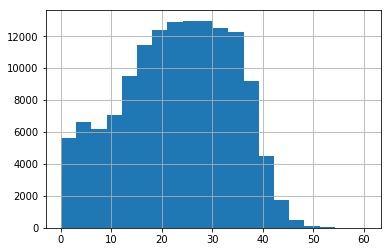

In [239]:
# ~20 min / game as threshold for inclusion in summary stats
boxes[boxes.mp_dec > 0].mp_dec.hist(bins = 20)

In [243]:
boxes.head().T.head().T

,player_id,player,team,gm,mp
0,priceaj01,A.J. Price,was,201210300CLE,29:24
5,crawfjo02,Jordan Crawford,was,201210300CLE,28:42
1,okafoem01,Emeka Okafor,was,201210300CLE,24:35
2,arizatr01,Trevor Ariza,was,201210300CLE,24:35
6,webstma02,Martell Webster,was,201210300CLE,23:25


In [251]:
cum_pm = boxes.groupby(['player_id', 'player']).plus_minus.sum().reset_index()
cum_pm.sort_values('plus_minus', ascending = False, inplace = True)

# net rating not as meaningful... lots of low min bigs
# cum_nr = boxes.groupby(['player_id', 'player']).net_rtg.sum().reset_index()
# cum_nr.sort_values('net_rtg', ascending = False, inplace = True)

In [258]:
cum_pm.head(10)

,player_id,player,plus_minus
163,curryst01,Stephen Curry,4172.0
368,jamesle01,LeBron James,3444.0
728,thompkl01,Klay Thompson,3443.0
277,greendr01,Draymond Green,3375.0
205,duranke01,Kevin Durant,3050.0
587,paulch01,Chris Paul,2927.0
444,leonaka01,Kawhi Leonard,2693.0
354,iguodan01,Andre Iguodala,2560.0
407,jordade01,DeAndre Jordan,2273.0
283,griffbl01,Blake Griffin,2219.0


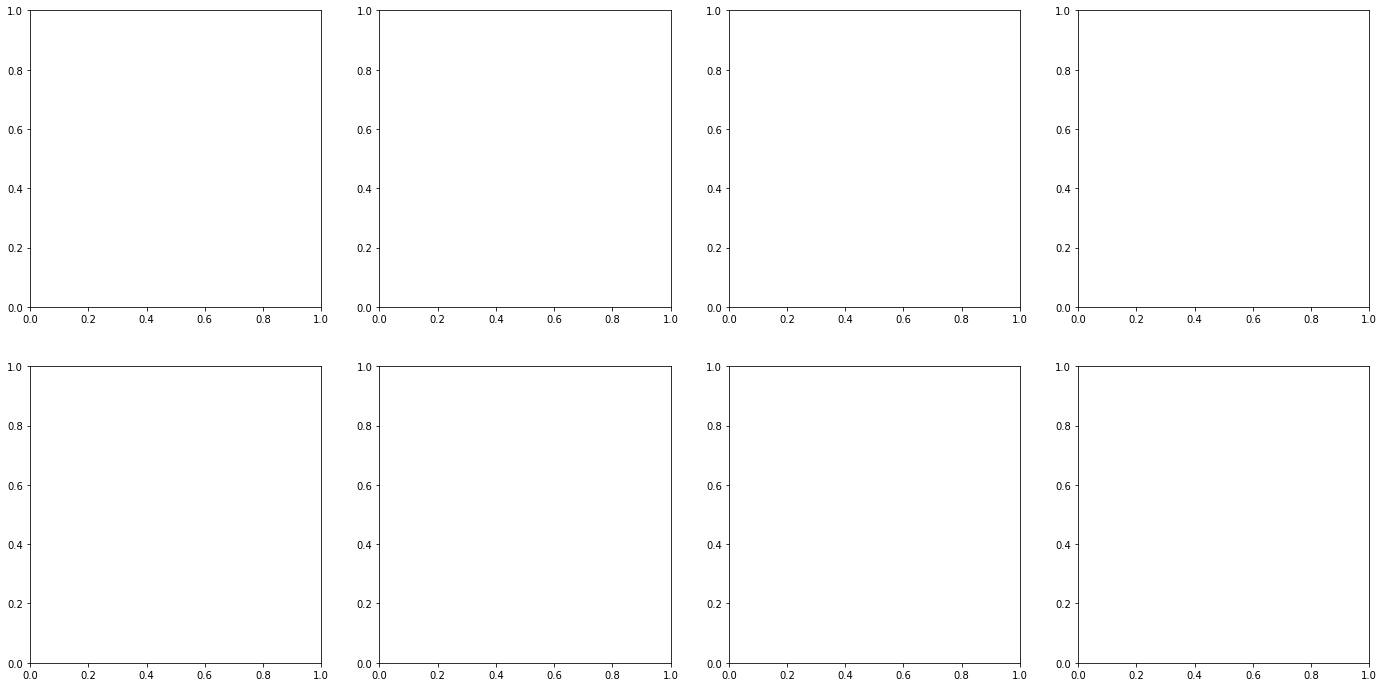

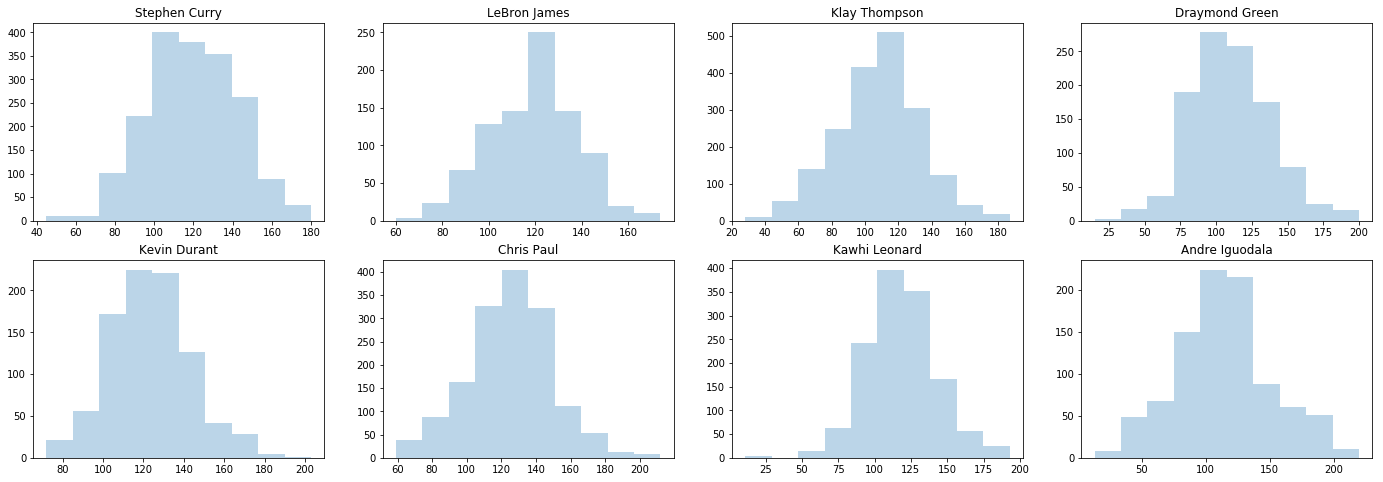

In [276]:
fig, axes = plt.subplots(2, 4, figsize  = (24,8))
for row, ax in zip(cum_pm.head(8).values, axes.flat):
    pid = row[0]
    name = row[1]
    
    ax.hist(g2g.loc[(g2g.mp_dec >= 20) & (g2g.mp_dec_next >= 20) & (g2g.player_id == pid), 'off_rtg'], alpha = .3)
    ax.set_title(name)

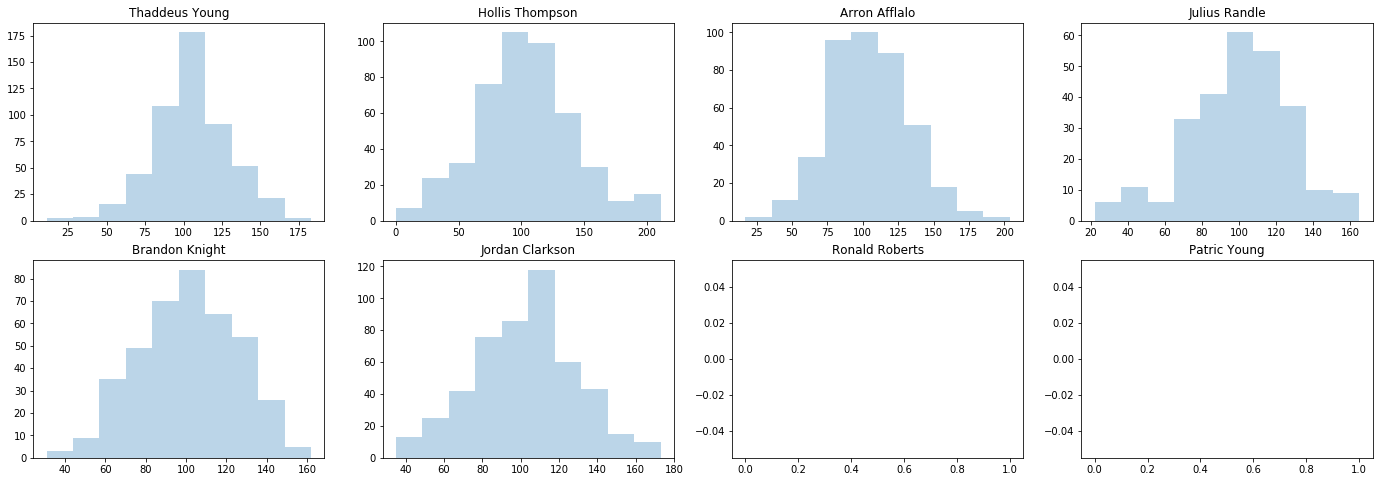

In [277]:
fig, axes = plt.subplots(2, 4, figsize  = (24,8))
for row, ax in zip(cum_pm.tail(8).values, axes.flat):
    pid = row[0]
    name = row[1]
    
    ax.hist(g2g.loc[(g2g.mp_dec >= 20) & (g2g.mp_dec_next >= 20) & (g2g.player_id == pid), 'off_rtg'], alpha = .3)
    ax.set_title(name)

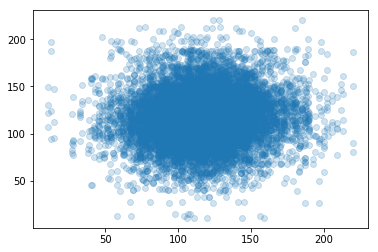

In [254]:
dfsample = g2g[(g2g.mp_dec >= 20) & (g2g.mp_dec_next >= 20) & (g2g.player_id.isin(cum_pm.head(10).player_id))]
plt.scatter(dfsample.off_rtg, dfsample.off_rtg_next, alpha = .2)

In [256]:
for 

array(['jamesle01', 'paulch01', 'griffbl01', 'jordade01', 'leonaka01',
       'iguodan01', 'thompkl01', 'curryst01', 'greendr01', 'duranke01'], dtype=object)